In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_train = pd.read_csv("../data/transformed_train.csv")
df_test = pd.read_csv("../data/transformed_test.csv")

# Separate our features (X) and target (y)
df_X = df_train.drop(["Status"], axis=1)
df_y = df_train[["Status"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2    # 80% Train - 20% Validation
)

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_y shape: {val_y.shape}")

train_X shape: (267700, 22)
train_y shape: (267700, 1)
val_X shape: (66926, 22)
val_y shape: (66926, 1)


In [3]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_depth": np.arange(2, 24, 2),
}

clf = RandomForestClassifier(
    criterion="gini",  # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0     # Reproducible result
)


tree_clf = RandomizedSearchCV(
    clf,
    params,
    scoring=["f1", "roc_auc"], refit="f1",
    return_train_score=True,
    n_jobs=-2
)
tree_clf.fit(train_X, train_y.values.ravel())

RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=0),
                   n_jobs=-2,
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                                        'n_estimators': array([ 5, 10, 15, 20])},
                   refit='f1', return_train_score=True,
                   scoring=['f1', 'roc_auc'])

In [4]:
tree_clf.best_params_

{'n_estimators': 20, 'max_depth': 22}

In [5]:
train_pred_y = tree_clf.predict(train_X)
val_pred_y = tree_clf.predict(val_X)

In [6]:
column_names = df_X.columns
feature_importances = pd.DataFrame(tree_clf.best_estimator_.feature_importances_, index = column_names, columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,importance
ExtraMedTest,0.375587
ExtraAlcoholTest,0.363983
BMI,0.050660
GenHlth,0.041188
Age,0.038461
Income,0.026778
HighBP,0.026731
Education,0.016969
PhysHlth,0.013834
HighChol,0.012729


[Text(0.45941920386090096, 0.9782608695652174, 'ExtraMedTest <= 0.123\ngini = 0.5\nsamples = 169256\nvalue = [134228.237, 133472.237]\nclass = HighBP'),
 Text(0.18532672907844874, 0.9347826086956522, 'BMI <= -0.058\ngini = 0.299\nsamples = 77949\nvalue = [100733.217, 22616.806]\nclass = HighBP'),
 Text(0.08708425114199092, 0.8913043478260869, 'ExtraAlcoholTest <= 1.473\ngini = 0.214\nsamples = 40943\nvalue = [56942.735, 7915.033]\nclass = HighBP'),
 Text(0.08702516672882839, 0.8478260869565217, 'Smoker <= 0.115\ngini = 0.132\nsamples = 38710\nvalue = [56942.735, 4364.261]\nclass = HighBP'),
 Text(0.05250140736591069, 0.8043478260869565, 'HighChol <= 0.153\ngini = 0.117\nsamples = 22104\nvalue = [32920.66, 2195.622]\nclass = HighBP'),
 Text(0.03534604208864324, 0.7608695652173914, 'ExtraMedTest <= 0.095\ngini = 0.092\nsamples = 14964\nvalue = [22676.231, 1149.279]\nclass = HighBP'),
 Text(0.027117329469920494, 0.717391304347826, 'HighBP <= 0.144\ngini = 0.129\nsamples = 10061\nvalue = [

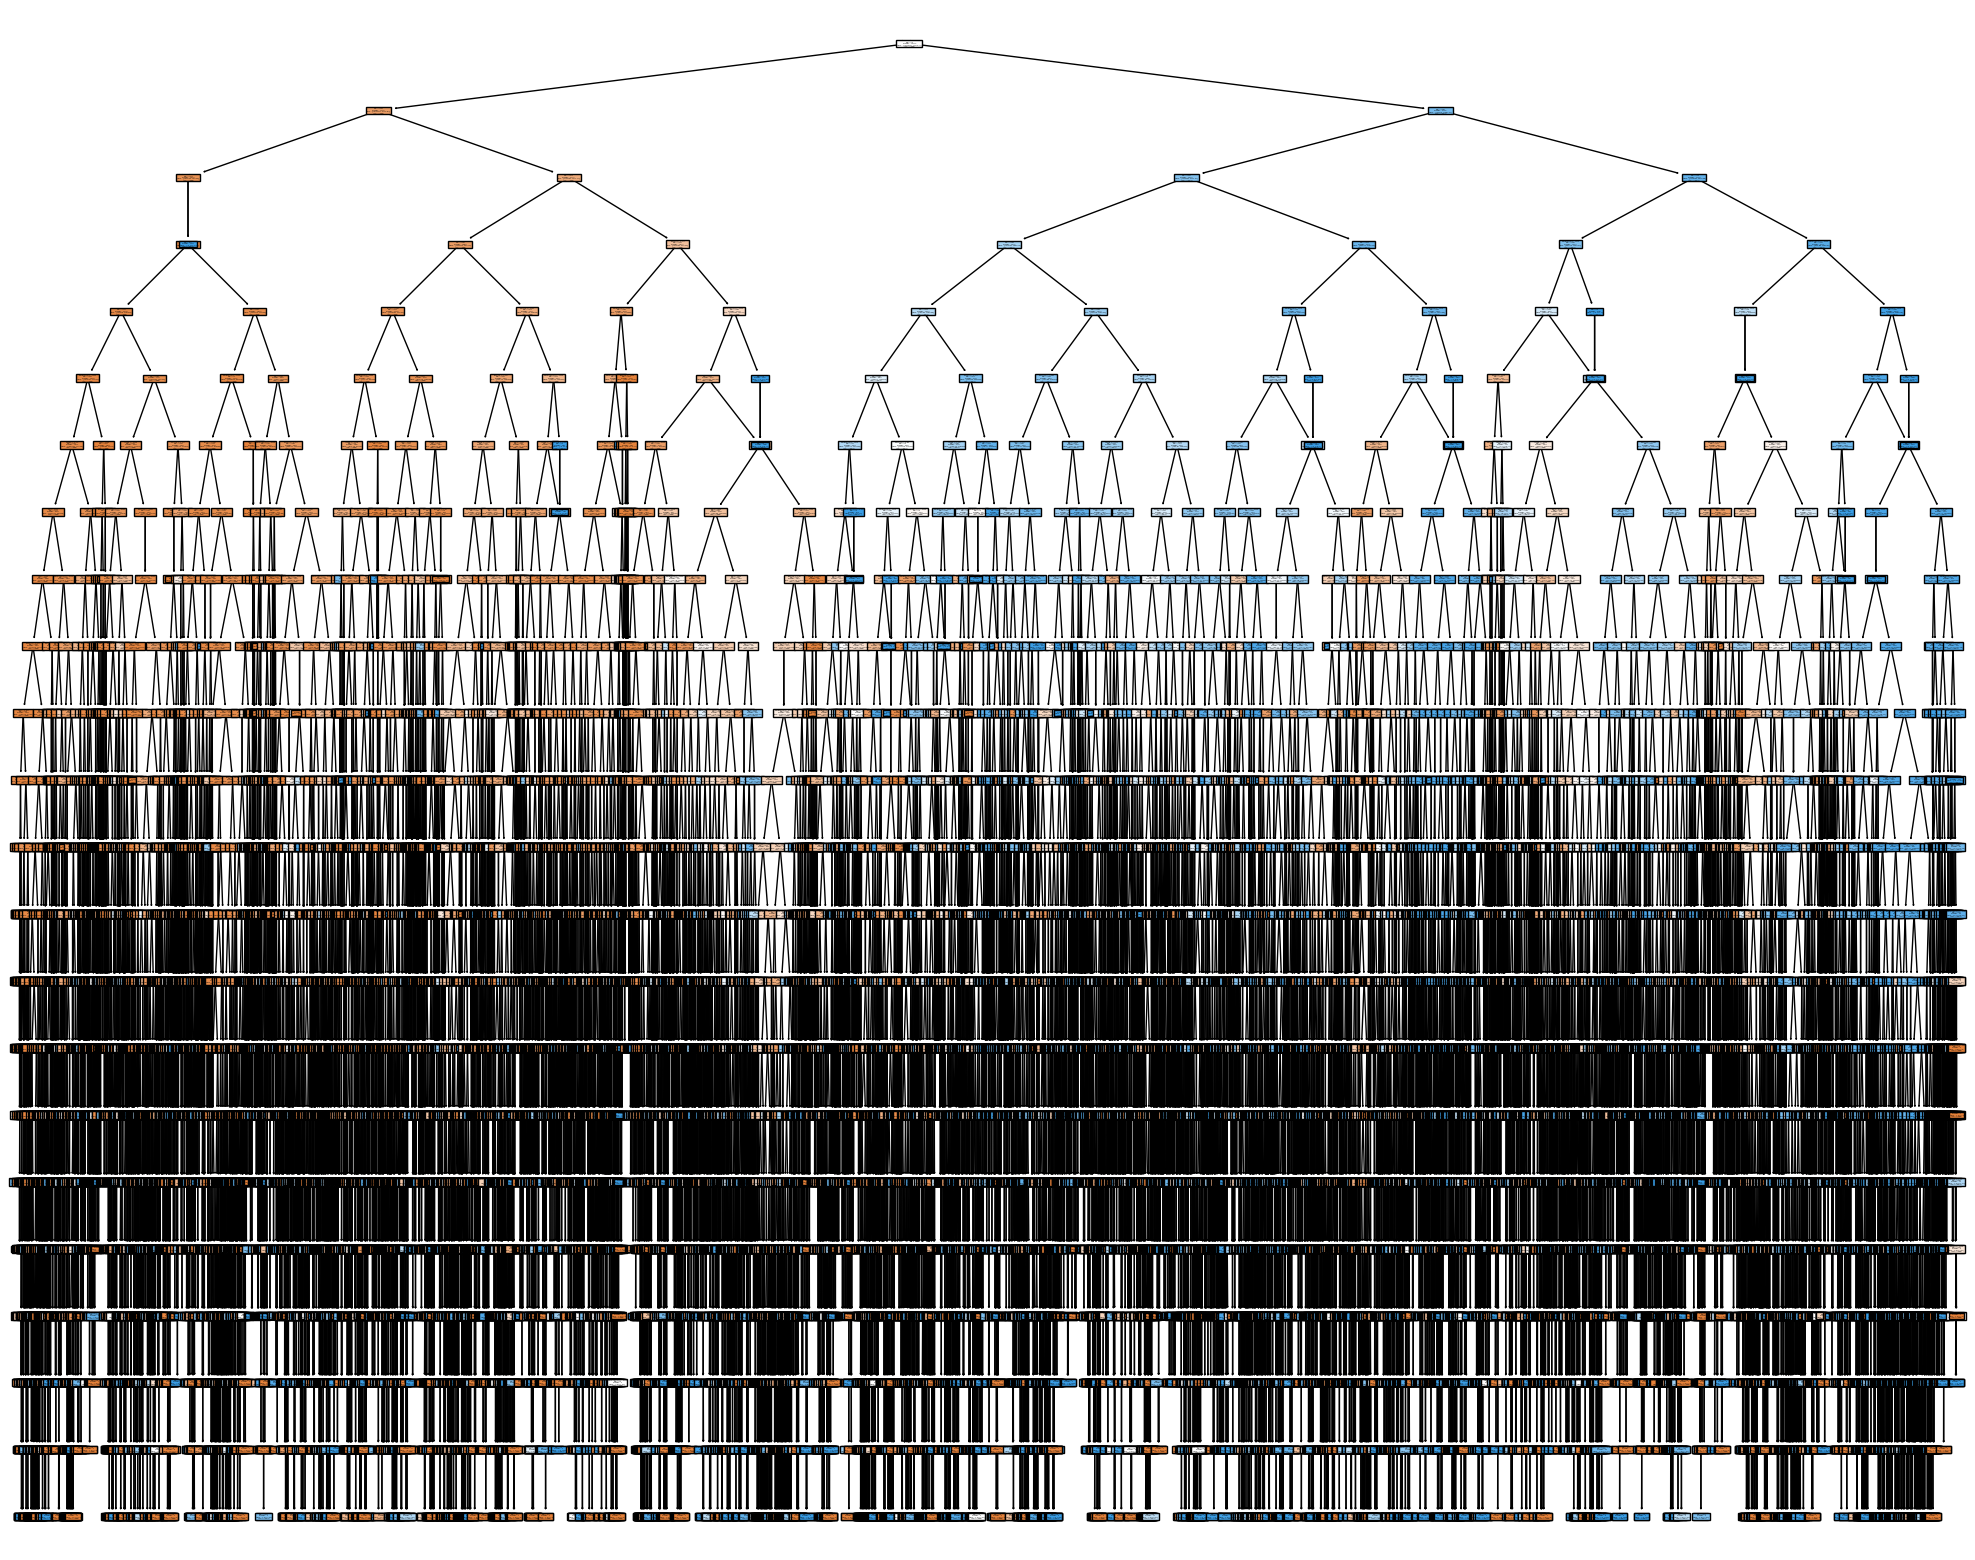

In [7]:
fig, ax = plt.subplots(figsize=(25,20))
decision_tree = tree_clf.best_estimator_.estimators_[0]
tree.plot_tree(
    decision_tree,
    feature_names=['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest'],
    class_names=['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest'],
    filled=True, ax=ax
)

In [8]:
export_path = "../data/out/s33925921_predictions.csv"

df_test_original = pd.read_csv("../data/data_test.csv")
patient_id = df_test_original["Id"].values

pred_y = tree_clf.predict(df_test)

df_export = pd.DataFrame({"Id": patient_id, "Status": pred_y})

In [9]:
df_export.head()

,Id,Status
0,202944,0
1,202945,0
2,202946,0
3,202947,0
4,202948,0


In [10]:
# df_export.to_csv(export_path, index=False)

In [11]:
accuracy = accuracy_score(val_y, val_pred_y)
precision = precision_score(val_y, val_pred_y)
recall = recall_score(val_y, val_pred_y)
f1 = f1_score(val_y, val_pred_y)
roc_auc = roc_auc_score(val_y, val_pred_y)

# Confusion matrix
conf_matrix = confusion_matrix(val_y, val_pred_y)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

Evaluation Metrics:
Accuracy: 0.9844
Precision: 0.9744
Recall: 0.9949
F1 Score: 0.9846
ROC AUC Score: 0.9845

Confusion Matrix:
[[32676   871]
 [  171 33208]]
